In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
src_path = '/Users/caritsang/Project/1d_AMR/src'

if src_path not in sys.path:
    sys.path.append(src_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import grid
import FVM
import viz
from misc import calc_L1_grid
import problem
import analytical

In [12]:
# Convergence study
reconstruction = ['godunov', 'MUSCL', 'PPM']
temporal_methods = ['RK1', 'RK2', 'RK3']
amr_methods = ['None', 'old', 'new']
bc_type = {'plane': 'periodic', 'sod': 'outflow'}

In [13]:
def evolve(prob, dx_type, dt_type, N, max_level=3, solve_method='None', 
           t_final=0.2, refine_epsilon=0.01, coarse_epsilon=0.005,
           plot=False):

    if solve_method == 'None':
        refine_epsilon = np.inf
        coarse_epsilon = np.inf
        solve_method = 'old'

    grid1 = grid.grid(L=1, N=N)
    grid1_history, init_con = FVM.run_sim(grid1, max_level=max_level, bc_type=bc_type[prob],
                            prob=prob, solve_method=solve_method, 
                            refine_epsilon=refine_epsilon, coarse_epsilon=coarse_epsilon,
                            t_final=t_final, 
                            dt_type=dt_type, dx_type=dx_type)
    
    print(f"Original cell number {N}, Final cell number: {len(grid1.get_all_active_cells())}")

    if plot:
        viz.plot_amr_grid(grid1)
        viz.plot_amr_value(grid1_history[-1], type=prob, init_con=init_con)

    return (calc_L1_grid(grid1, type=prob, init_con=init_con)), len(grid1.get_all_active_cells()), grid1

In [14]:
def error_graph(prob, grid1):

    tmp = grid.grid(grid1.L, grid1.N)
    
    grid1_active = grid1.get_all_active_cells()

    X = np.array([c.x for c in grid1_active])
    prim = np.array([c.prim for c in grid1_active])
    
    if prob == 'sod':
        _, init_con = problem.sod_rod_tube(tmp)
        rho_analytic, u_analytic, P_analytic = analytical.get_sod_solution(X, grid1.t, *init_con)
    elif prob == 'plane':
        _, init_con = problem.plane_wave(tmp)
        rho_analytic, u_analytic, P_analytic = analytical.get_plane_wave_solution(X, grid1.t, *init_con)

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].plot(X, np.abs(rho_analytic - prim[:, 0]))
    ax[0].set_title("Density")
    ax[1].plot(X, np.abs(u_analytic - prim[:, 1]))
    ax[1].set_title("Velocity")
    ax[2].plot(X, np.abs(P_analytic - prim[:, 2]))
    ax[2].set_title("Pressure")

    for axes in ax:
        axes.set_xlabel('X')
        axes.set_ylabel('Absolute error')

    plt.tight_layout()

In [15]:
def compare_L1(prob, N, amr_methods, **kwargs):
    
    MSE = {}
    N_dict = {}
    final_grid = {}

    for amr_method in amr_methods:
        MSE[amr_method] = {}
        final_grid[amr_method] = {}
        N_dict[amr_method] = {}

        for temporal_method in temporal_methods:
            MSE[amr_method][temporal_method] = {}
            final_grid[amr_method][temporal_method] = {}
            N_dict[amr_method][temporal_method] = {}

            for i, method in enumerate(reconstruction[:-1]):
                tmp = []
                tmp2 = []
                for n in N:
                    error, final_cells, _ = evolve(prob=prob, dx_type=method, dt_type=temporal_method, N=n, solve_method=amr_method,
                                **kwargs)
                    print(f"L1 error: {error}")
                    tmp.append(error)
                    tmp2.append(final_cells)

                MSE[amr_method][temporal_method][method] = tmp
                final_grid[amr_method][temporal_method][method] = tmp2
                N_dict[amr_method][temporal_method][method] = N

            print('\n')

    return MSE, final_grid, N_dict

Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:01<00:00,  9.38s/s]                 


FINISHED
Original cell number 50, Final cell number: 167


0.024192587405577955

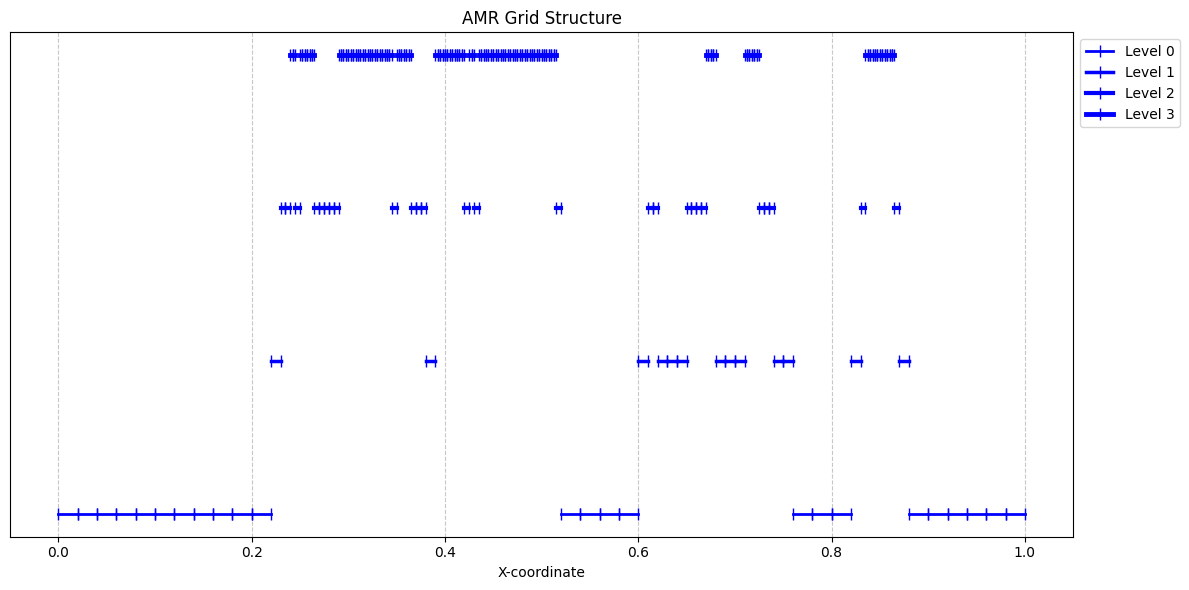

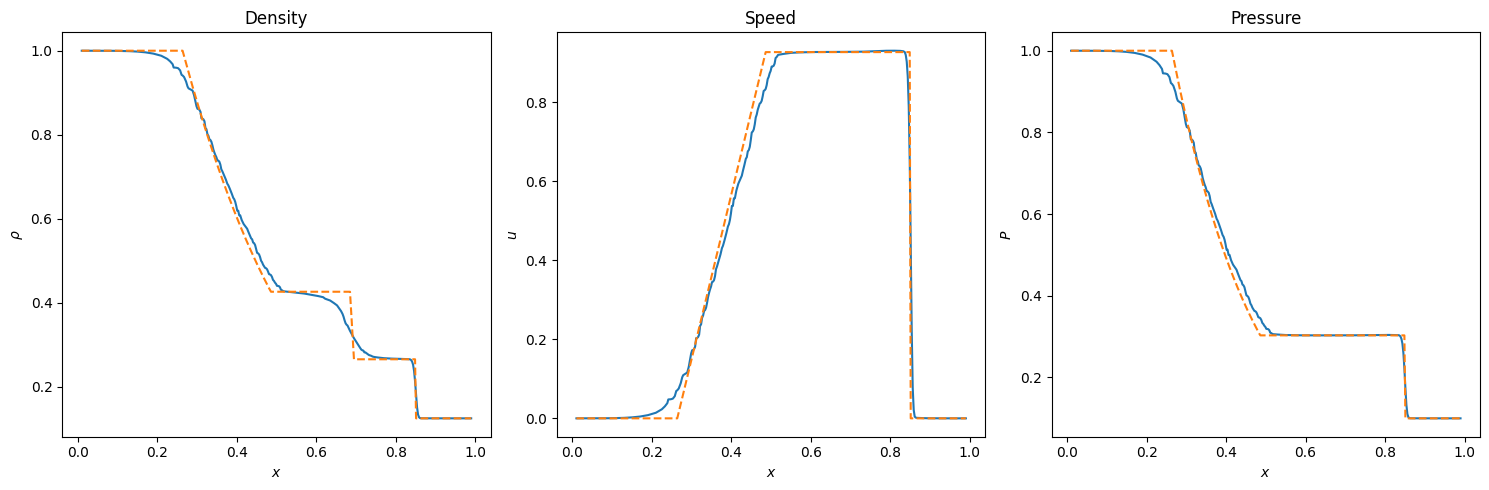

In [ ]:
l1, _, grid1 = evolve(prob='sod', dx_type='godunov', dt_type='RK1', 
                      N=50, max_level=3,
                      #refine_epsilon=np.inf, 
                      #coarse_epsilon=np.inf,
                      solve_method='new', plot=True, t_final=0.2)
l1

In [1]:
l1, _, grid1 = evolve(prob='sod', dx_type='godunov', dt_type='RK1', 
                      N=10, max_level=1,
                      #refine_epsilon=np.inf, 
                      coarse_epsilon=np.inf,
                      solve_method='new', plot=True, t_final=0.2)
l1

NameError: name 'evolve' is not defined

Using new method now
Using godunov in spatial and RK2 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.68s/s]                

FINISHED
Original cell number 50, Final cell number: 50


6.77053771349286e-08

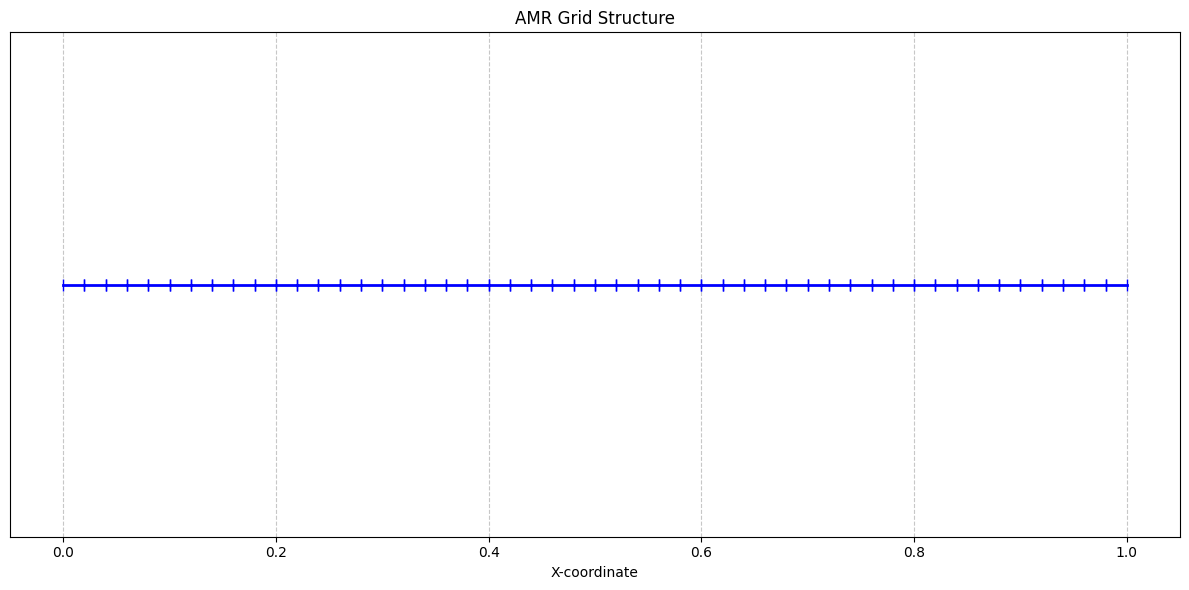

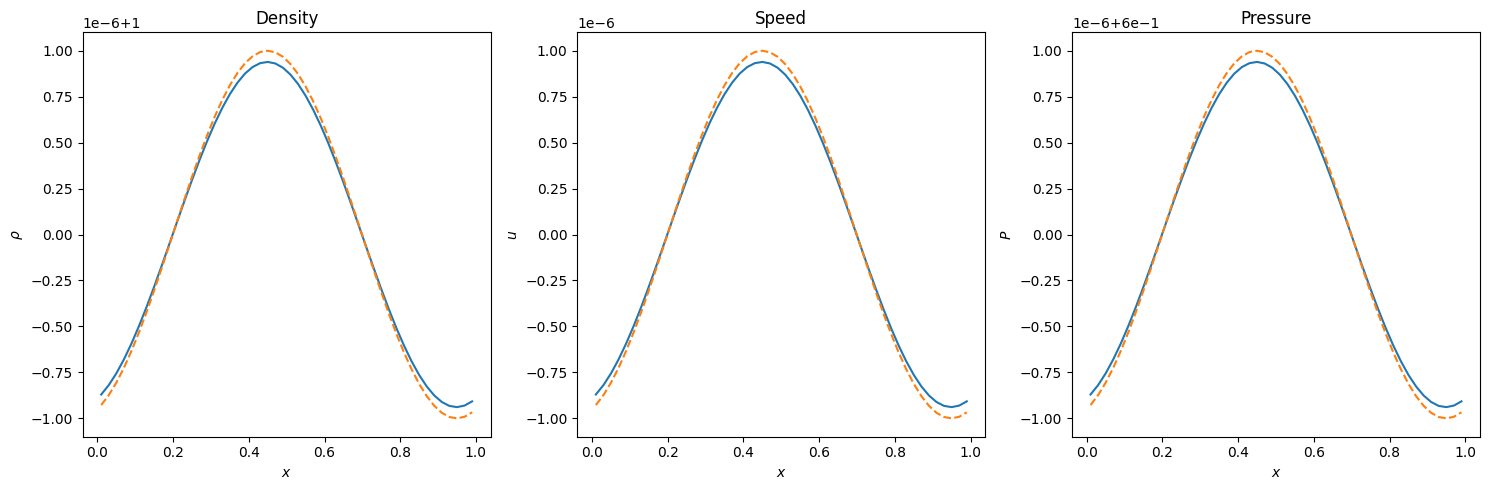

In [14]:
# CFL=0.5

l1, _, grid1 = evolve(prob='plane', dx_type='godunov', dt_type='RK2', 
                      N=50, 
                      #refine_epsilon=np.inf, coarse_epsilon=np.inf,
                      solve_method='new', plot=True, t_final=0.2)
l1

In [1]:
# CFL=1
l1, _, grid1 = evolve(prob='sod', dx_type='godunov', dt_type='RK1', 
                      N=10, 
                      #refine_epsilon=np.inf, 
                      coarse_epsilon=np.inf,
                      solve_method='None', plot=True, t_final=0.2)
l1

NameError: name 'evolve' is not defined

In [125]:
l1, _, grid1 = evolve(prob='sod', dx_type='godunov', dt_type='RK1', 
                      N=10, 
                      coarse_epsilon=0.1,
                      refine_epsilon=np.inf, coarse_epsilon=np.inf,
                      solve_method='new', plot=True, t_final=0.2)
l1

SyntaxError: keyword argument repeated: coarse_epsilon (444299473.py, line 1)

Using old method now
Using MUSCL in spatial and RK2 in temporal.
Using linear reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.15s/s]                


FINISHED
Original cell number 50, Final cell number: 50


0.025394946479426778

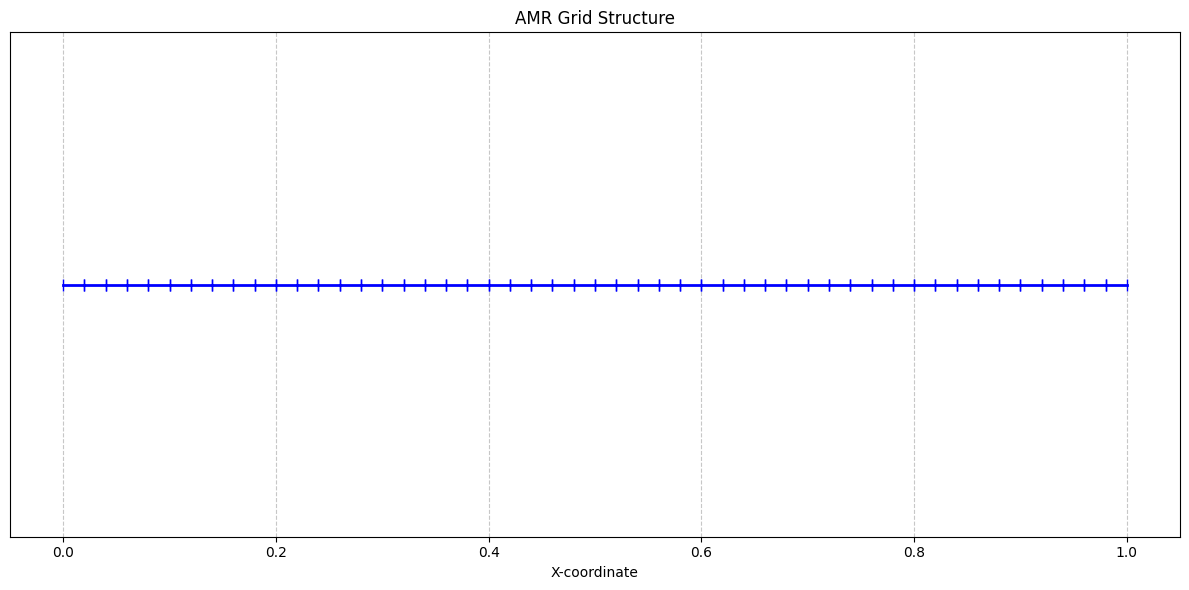

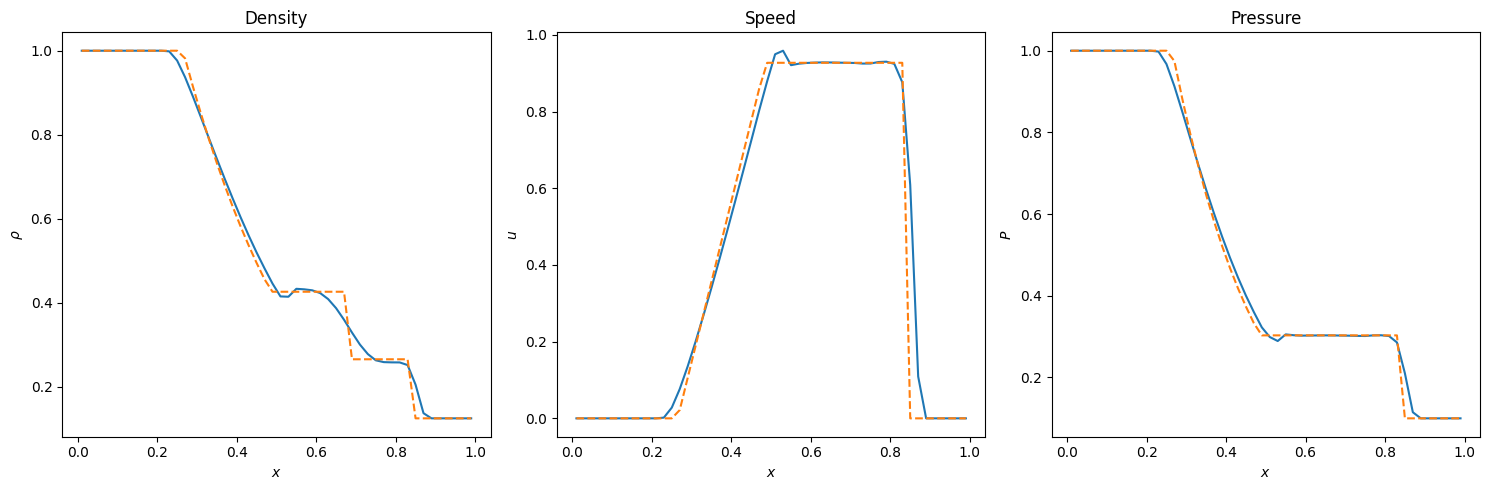

In [25]:
l1, _, grid1 = evolve(prob='sod', dx_type='MUSCL', dt_type='RK2', 
                      N=50, 
                      #refine_epsilon=np.inf, coarse_epsilon=np.inf,
                      solve_method='None', plot=True, t_final=0.2)
l1

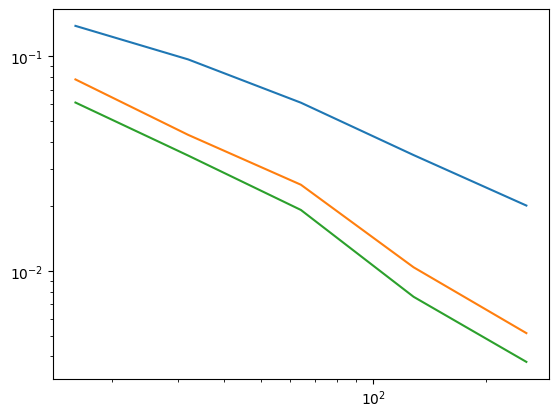

In [541]:
plt.loglog(N, tmp1)
plt.loglog(N, tmp2)
plt.loglog(N, tmp3)

In [542]:
N = [2 ** n for n in range(4, 9)]
tmp3 = []
for n in N:
    l1, _, grid1 = evolve(prob='sod', dx_type='PPM', dt_type='RK3', 
                        N=n, 
                        #refine_epsilon=np.inf, coarse_epsilon=np.inf,
                        solve_method='old', plot=False, t_final=0.2)
    tmp3.append(l1)
    print(l1)


Using old method now
Using PPM in spatial and RK3 in temporal.
Using PPM reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  4.43s/s]                


FINISHED
Original cell number 16, Final cell number: 84
0.02813477311103917
Using old method now
Using PPM in spatial and RK3 in temporal.
Using PPM reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:02<00:00, 13.36s/s]                 


FINISHED
Original cell number 32, Final cell number: 124
0.013873422458600826
Using old method now
Using PPM in spatial and RK3 in temporal.
Using PPM reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:08<00:00, 43.04s/s]                 


FINISHED
Original cell number 64, Final cell number: 182
0.0067869520238843595
Using old method now
Using PPM in spatial and RK3 in temporal.
Using PPM reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:25<00:00, 125.68s/s]                 


FINISHED
Original cell number 128, Final cell number: 230
0.0038993087509798393
Using old method now
Using PPM in spatial and RK3 in temporal.
Using PPM reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [01:19<00:00, 397.43s/s]                  


FINISHED
Original cell number 256, Final cell number: 360
0.0028052385098351704


Using old method now
Using godunov in spatial and RK1 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  2.02s/s]                


FINISHED
Original cell number 100, Final cell number: 100
0.04235284286601935
Using old method now
Using godunov in spatial and RK2 in temporal.
Using zero-th order reconstruction


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  3.10s/s]                


FINISHED
Original cell number 100, Final cell number: 100
0.051284537927758764


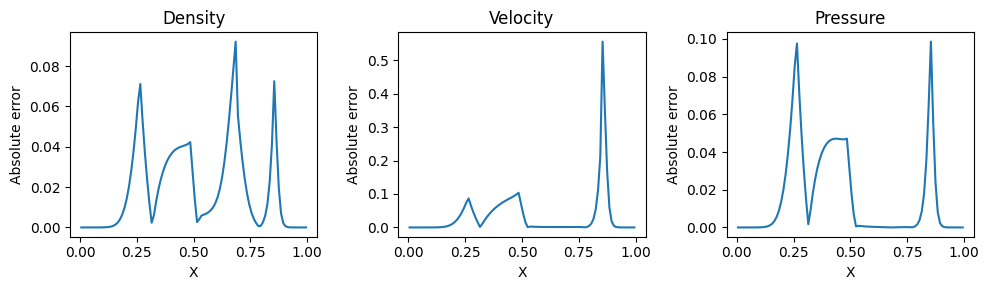

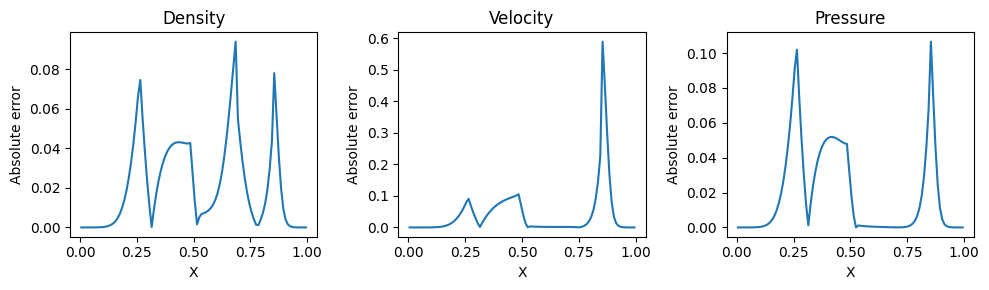

In [ ]:
prob = 'sod'

l1, _, grid1 = evolve(prob=prob, dx_type='godunov', dt_type='RK1', 
                      N=100, #refine_epsilon=np.inf, coarse_epsilon=np.inf, 
                      solve_method='None', plot=False, t_final=0.2)
error_graph(prob=prob, grid1=grid1)
print(l1)

l1, _, grid1 = evolve(prob=prob, dx_type='godunov', dt_type='RK2', 
                      N=100, 
                      refine_epsilon=np.inf, coarse_epsilon=np.inf,
                      solve_method='None', plot=False, t_final=0.2)
error_graph(prob=prob, grid1=grid1)
print(l1)

In [ ]:
N = [2 ** n for n in range(4, 8)]
sod_MSE, sod_final_gridm, N_dict = compare_L1(prob='sod', N=N, amr_methods=['None', 'new'],
                                              refine_epsilon=np.inf, coarse_epsilon=np.inf
                                              )

In [ ]:
plane_MSE, plane_final_grid, N_dict = compare_L1(prob='plane', N=N, amr_methods=['None', 'new']
                                                 #refine_epsilon=1e-7, coarse_epsilon=1e-8
                                                 )

In [381]:
colormap = {'new': 'b',
            'old': 'g',
            'None': 'r'}

linestyle_map = {
    'godunov': '-',
    'MUSCL': '--',
    'PPM': ':'
}

linestyle_map2 = {
    'RK1': '-',
    'RK2': '--',
    'RK3': ':'
}

In [373]:
def compare(ax, dict_x, dict_y, xlabel=None, ylabel=None, scale='log', title=None, legend=False):
    for amr_method in amr_methods:
        for i, method in enumerate(reconstruction):
            try:
                ax.plot(dict_x[amr_method][method], dict_y[amr_method][method], 
                     label=f'{amr_method} + {method} + {temporal_methods[i]}', 
                     color=colormap[amr_method],
                     linestyle=linestyle_map[method])
            except:
                pass

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    if title is not None:
        ax.set_title(title)
        
    if legend:
        ax.legend(frameon=False, bbox_to_anchor=(1.08, 0.6))
    ax.set_xscale(scale)
    ax.set_yscale(scale)

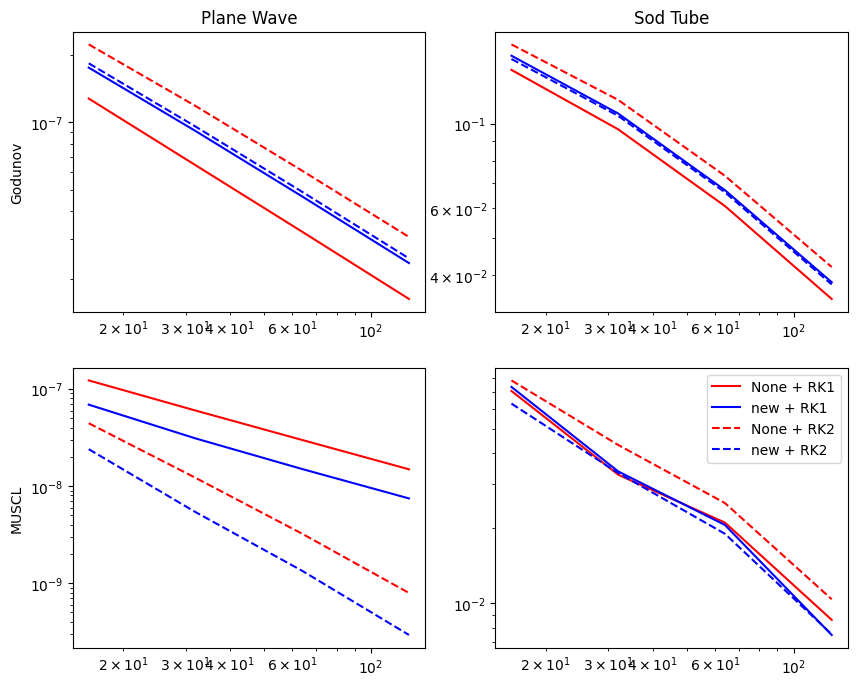

In [438]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for tmp in temporal_methods[:-1]:
    for met in ['None', 'new']:
        ax[0][0].loglog(N, plane_MSE[met][tmp]['godunov'], label=f'{met} + {tmp}', color=colormap[met], linestyle=linestyle_map2[tmp])
        ax[0][1].loglog(N, sod_MSE[met][tmp]['godunov'], label=f'{met} + {tmp}', color=colormap[met], linestyle=linestyle_map2[tmp])

        ax[1][0].loglog(N, plane_MSE[met][tmp]['MUSCL'], label=f'{met} + {tmp}', color=colormap[met], linestyle=linestyle_map2[tmp])
        ax[1][1].loglog(N, sod_MSE[met][tmp]['MUSCL'], label=f'{met} + {tmp}', color=colormap[met], linestyle=linestyle_map2[tmp])

ax[0][0].set_ylabel("Godunov")
ax[1][0].set_ylabel("MUSCL")
ax[0][0].set_title('Plane Wave')
ax[0][1].set_title('Sod Tube')
plt.legend()

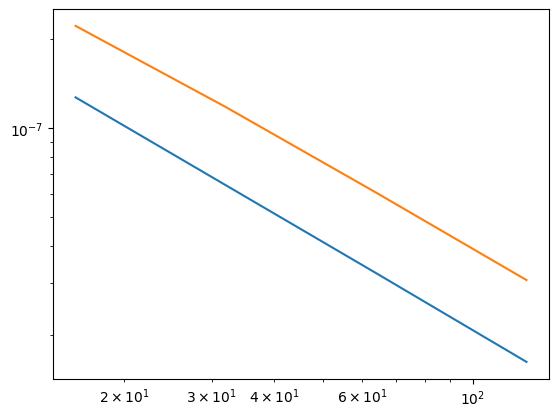

In [437]:
plt.loglog(N, plane_MSE['None']['RK1']['godunov'])
plt.loglog(N, plane_MSE['None']['RK2']['godunov'])

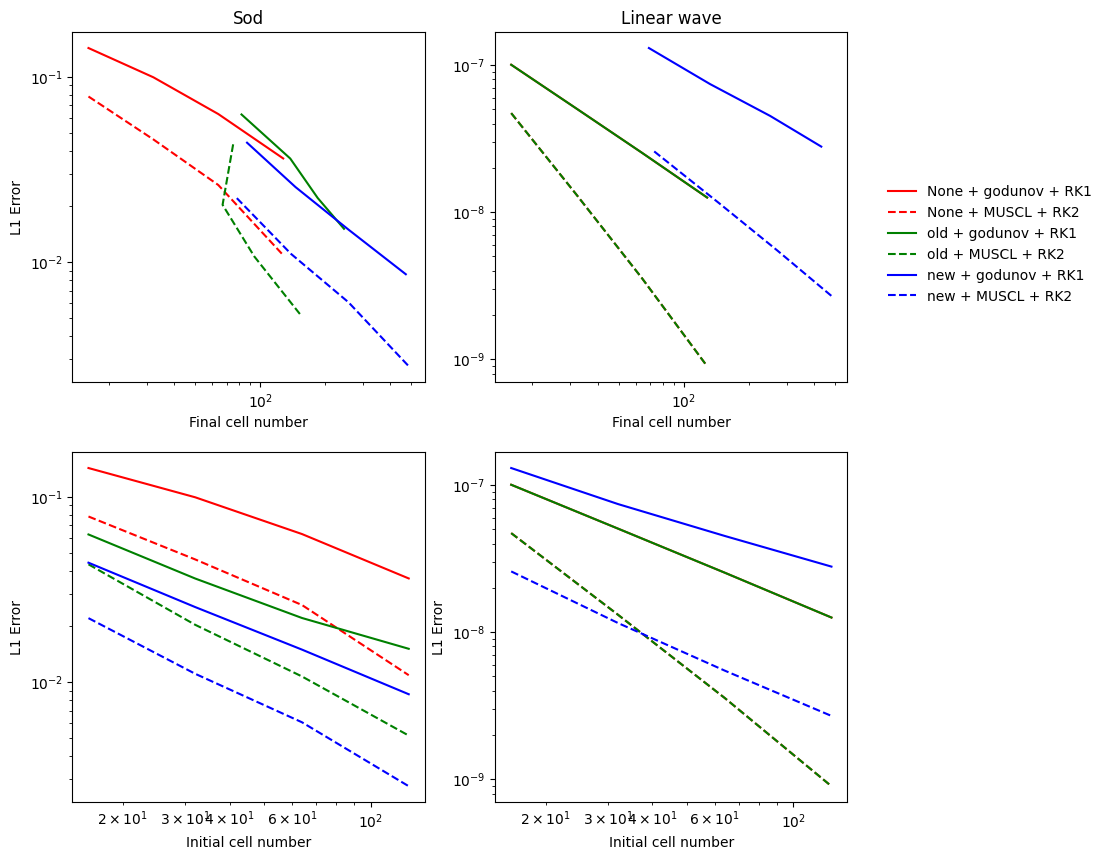

In [164]:
# Forced no refinement
fig, ax = plt.subplots(2, 2, figsize=(10,10))
compare(ax[0][0], sod_final_gridm, sod_MSE, xlabel='Final cell number', ylabel='L1 Error', title='Sod')
compare(ax[0][1], plane_final_grid, plane_MSE, xlabel='Final cell number', title='Linear wave', legend=True)
compare(ax[1][0], N_dict, sod_MSE, xlabel='Initial cell number', ylabel='L1 Error', )
compare(ax[1][1], N_dict, plane_MSE, xlabel='Initial cell number', ylabel='L1 Error', )
#plt.tight_layout()